In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import pandas_ta as ta
import quantstats as qs
qs.extend_pandas()

import numpy as np
import datetime
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn

params = {'figure.facecolor': 'w'}
plt.rcParams.update(params)

from IPython.display import display

## Data Preparation

In [2]:
# Data Directory
data_dir = '/workspace/202205_idx-trading/_data/'
lq45_dir = '/workspace/202205_idx-trading/_data/20220525_lq45/'
lq45_index_file = data_dir + '20220525_lq45_index.csv'
lq45_list = '20220525_lq45-list.txt'
issi_list = '20220525_issi-list.txt'

# Prepare Stock Tickers
with open(data_dir + lq45_list, "r") as f:
    lq45_tickers = f.read().split('\n')

with open(data_dir + issi_list, "r") as f:
    issi_tickers = f.read().split('\n')

## Prepare active tickers for international codes
active_tickers_international = [f + '.JK' for f in lq45_tickers]

In [3]:
# Read downloaded stock Adjusted Close Price data
lq45_df_dict = {}
for ticker in tqdm(active_tickers_international):
    lq45_df_dict[ticker] = pd.read_csv(lq45_dir + ticker + '.csv')
    
lq45_index_data = pd.read_csv(lq45_index_file)

100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 140.16it/s]


In [4]:
# Do Some basic data Operations (Fill NaN, take only certain data range, generate in sample an dout of sample data)
date_start = '2021-01-01'
date_breakpoint = '2022-01-01'

lq45_in_df = {}
lq45_out_df = {}
for ticker in tqdm(active_tickers_international):
    # Fill NaN values with the earliest data
    lq45_df_dict[ticker].fillna(method='bfill', axis=0, inplace=True)
    
    # Take In Sample and Out Sample Data
    lq45_df_dict[ticker]['Date'] = pd.to_datetime(lq45_df_dict[ticker]['Date'])
    lq45_in_df[ticker] = lq45_df_dict[ticker][(lq45_df_dict[ticker]['Date'] >= date_start) & 
                                                (lq45_df_dict[ticker]['Date'] < date_breakpoint)]
    lq45_out_df[ticker] = lq45_df_dict[ticker][lq45_df_dict[ticker]['Date'] >= date_breakpoint]
    
    # Reset Index After Dropped
    lq45_in_df[ticker] = lq45_in_df[ticker].reset_index(drop=True)
    lq45_out_df[ticker] = lq45_out_df[ticker].reset_index(drop=True)

# Do the same for lq45 index data, and add to df dictionary
lq45_index_data.fillna(method='bfill', axis=0, inplace=True)
lq45_index_data['Date'] = pd.to_datetime(lq45_index_data['Date'])
lq45_in_df['LQ45'] = lq45_index_data[(lq45_index_data['Date'] >= date_start) & 
                                (lq45_index_data['Date'] < date_breakpoint)]
lq45_out_df['LQ45'] = lq45_index_data[lq45_index_data['Date'] >= date_breakpoint]
lq45_in_df['LQ45'] = lq45_in_df['LQ45'].reset_index(drop=True)
lq45_out_df['LQ45'] = lq45_out_df['LQ45'].reset_index(drop=True)

100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 293.76it/s]


## Data Exploration
We will test for cointegration on in-sample data

In [5]:
# List of Cointegrated Pairs (Based on LQ45 2020-2021, Tested w/ stattools.coint)
coint_pairs = [['HRUM.JK', 'ADRO.JK'],
             ['PGAS.JK', 'LQ45'],
             ['TPIA.JK', 'ITMG.JK'],
             ['INCO.JK', 'ANTM.JK'],
             ['AMRT.JK', 'UNVR.JK'],
             ['CPIN.JK', 'JPFA.JK'],
             ['ICBP.JK', 'LQ45'],
             ['BBNI.JK', 'BMRI.JK'],
             ['BBRI.JK', 'BBTN.JK'],
             ['GGRM.JK', 'HMSP.JK'],
             ['INTP.JK', 'PTPP.JK'],
             ['INTP.JK', 'WIKA.JK'],
             ['SMGR.JK', 'WSKT.JK'],
             ['KLBF.JK', 'LQ45']]

In [6]:
import statsmodels.api as sm

def calc_beta(S1, S2):
    '''
    Calculate beta from two price series by doing regression.
    '''
    S1 = sm.add_constant(S1)
    results = sm.OLS(S2, S1).fit()
    S1 = S1['Adj Close']
    b = results.params['Adj Close']
    
    return b

def calc_half_life(S):
    '''
    Calculate half life from a price series
    '''
    S_lag = S.shift(periods=1).iloc[1:]
    S_diff = S.iloc[1:] - S_lag

    S_lag = sm.add_constant(S_lag)
    results = sm.OLS(S_diff, S_lag).fit()
    S_lag = S_lag['Adj Close']
    lbd = results.params['Adj Close']

    half_life = -np.log(2) / lbd
    
    return lbd, half_life

In [7]:
# Calculate Half Life for All Pairs

pair_df = pd.DataFrame(columns=['ticker_1', 'ticker_2', 'beta', 'lambda', 'half_life'])
for pair in tqdm(coint_pairs):
    # Regression to get Beta for Price Spread Model
    S1 = lq45_in_df[pair[0]]['Adj Close']
    S2 = lq45_in_df[pair[1]]['Adj Close']
    b = calc_beta(S1, S2)
    spread = S2 - b * S1
    
    # Ornstein-Uhlenbeck Formula to Calculate Half Life
    lbd, half_life = calc_half_life(spread)
    
    # Append to df
    buff = pd.DataFrame({"ticker_1": [pair[0]],
                          "ticker_2": [pair[1]],
                          "beta": [b],
                          "lambda": [lbd],
                          "half_life": [half_life]})
    pair_df = pd.concat([pair_df, buff])

pair_df = pair_df.reset_index(drop=True)

display(pair_df)

100%|███████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 186.05it/s]


,ticker_1,ticker_2,beta,lambda,half_life
0,HRUM.JK,ADRO.JK,0.598377,-0.042583,16.277389
1,PGAS.JK,LQ45,0.230747,-0.277809,2.495054
2,TPIA.JK,ITMG.JK,-2.136933,-0.044811,15.468065
3,INCO.JK,ANTM.JK,0.282057,-0.175586,3.947628
4,AMRT.JK,UNVR.JK,-4.607112,-0.087670,7.906314
5,CPIN.JK,JPFA.JK,0.410983,-0.093812,7.388697
6,ICBP.JK,LQ45,0.088955,-0.087703,7.903354
7,BBNI.JK,BMRI.JK,0.602237,-0.115858,5.982756
8,BBRI.JK,BBTN.JK,0.613750,-0.100368,6.906054
9,GGRM.JK,HMSP.JK,0.032803,-0.016884,41.052341


## Strategy

### Baseline Strategy

Buy and Hold LQ45

In [8]:
# Simple buy and hold strategy
b_df = lq45_out_df['LQ45'].copy()

b_df['signal'] = ''
b_df['close'] = b_df['Adj Close']
b_df = b_df[['Date', 'close', 'signal']]
b_df = b_df.reset_index(drop=True)

b_df['signal'][0] = 'buy'
b_df['signal'][len(b_df)-1] = 'sell'

def calc_returns_benchmark(df):
    '''
    Calculate returns and cumulative returns per entry on dataframe.
    Used for benchmark calculation.
    '''
    df_proc = df.copy()
    
    last_signal = ''
    df_proc['return'] = np.nan
    for i in range(0, len(df_proc)):
        if last_signal == 'buy':
            df_proc["return"][i] = (df_proc['close'][i] - df_proc['close'][i-1]) / df_proc['close'][i-1]
        elif last_signal == 'sell':
            df_proc["return"][i] = 0
        else:
            df_proc["return"][i] = 0
        
        if not(df_proc["signal"][i] == ''):
            last_signal = df_proc["signal"][i] 

    df_proc["cum_return"] = (1 + df_proc["return"]).cumprod()
    return df_proc

### Trading Strategy
Simple Bollinger Band-based long only strategy adapted from:
https://github.com/quantopian/research_public/blob/master/notebooks/lectures/Introduction_to_Pairs_Trading/notebook.ipynb

For v0.2, we do both "long the spread" and "short the spread", but only long one of the ticker in the pair.

Note: We assume that within one period we cannot go from long position to short position. Long/Short positions must be exited before changing positions to Short/Long.

In [9]:
from statsmodels.regression.rolling import RollingOLS

def strategy(df_dict, pair, lookback, beta_lookback=30, std=1):
    '''
    Long-Only Bollinger Band Mean Reversion Strategy
    
    1. Calculate the Rolling Price Spread, by first estimating the beta model of the pair.
       We assume the model is of the form Y = beta * X where Y is the second item in the pair.
    2. Calculate the BBands
    3. Generate Signal, based on BBand (long when price >= bbl, exit when price <= bbm)
    4. Calculate Returns
    '''
    
    # Take the relevant price series from each pair
    df_proc = pd.concat([df_dict[pair[0]]['Date'], df_dict[pair[0]]['Adj Close'], df_dict[pair[1]]['Adj Close']], 
                            axis=1,
                            keys=['Date', pair[0], pair[1]])
    
    # Calculate Rolling Price Spread using Beta Model
    S1 = df_proc[pair[0]]
    S2 = df_proc[pair[1]]
    
    S1_indep = sm.add_constant(S1)
    result = RollingOLS(S2, S1_indep, window=beta_lookback).fit()
    rolling_beta = result.params[pair[0]]
    
    ## add Rolling Beta to main df
    df_proc['beta'] = rolling_beta
    
    ## calculate rolling spread
    df_proc['spread'] = df_proc[pair[1]] - df_proc['beta'] * df_proc[pair[0]]
    
    # Generate Technical Indicators (BBand)
    df_proc.set_index('Date')
    bbands = ta.bbands(df_proc['spread'], length=lookback, std=std)
    
    bbands_upper_cname = 'BBU' + '_' + str(lookback) + '_' + str(std) + '.0'
    bbands_lower_cname = 'BBL' + '_' + str(lookback) + '_' + str(std) + '.0'
    bbands_mid_cname = 'BBM' + '_' + str(lookback) + '_' + str(std) + '.0'
    
    df_proc['spread_BBU'] = bbands[bbands_upper_cname]
    df_proc['spread_BBL'] = bbands[bbands_lower_cname]
    df_proc['spread_BBM'] = bbands[bbands_mid_cname]
    
    # Signal Rules
    long_signal = lambda price, bbl: (price <= bbl)
    long_close_signal = lambda price, bbm: (price >= bbm)
    short_signal = lambda price, bbu: (price >= bbu) # note: might be better to set absolute differences   
    short_close_signal = lambda price, bbm: (price <= bbm)
    
    # Generate Signals
    ## This Signal generation is for a long-only strategy
    last_signal = ''
    df_proc['signal'] = ''
    df_proc['signal_ticker'] = ''
    for i in range(0, len(df_proc)):
        if i == 0:
            df_proc['signal'][i] = ''
        
        elif last_signal == '':
            if long_signal(df_proc['spread'][i], df_proc['spread_BBL'][i]):
                df_proc['signal'][i] = 'long_entry'
                last_signal = 'long_entry'
                df_proc['signal_ticker'][i] = pair[1]
            elif long_close_signal(df_proc['spread'][i], df_proc['spread_BBM'][i]):
                df_proc['signal'][i] = 'long_close'
                last_signal = 'long_close'
                df_proc['signal_ticker'][i] = pair[1]
            elif short_signal(df_proc['spread'][i], df_proc['spread_BBU'][i]):
                df_proc['signal'][i] = 'short_entry'
                last_signal = 'short_entry'
                df_proc['signal_ticker'][i] = pair[0]
            elif short_close_signal(df_proc['spread'][i], df_proc['spread_BBM'][i]):
                df_proc['signal'][i] = 'short_close'
                last_signal = 'short_close'
                df_proc['signal_ticker'][i] = pair[0]
            else:
                df_proc['signal'][i] = ''
            
        elif last_signal == 'long_entry':
            if long_close_signal(df_proc['spread'][i], df_proc['spread_BBM'][i]):
                df_proc['signal'][i] = 'long_close'
                last_signal = 'long_close'
                df_proc['signal_ticker'][i] = pair[1]
            else:
                df_proc['signal'][i] = ''
                
        elif last_signal == 'short_entry':
            if short_close_signal(df_proc['spread'][i], df_proc['spread_BBM'][i]):
                df_proc['signal'][i] = 'short_close'
                last_signal = 'short_close'
                df_proc['signal_ticker'][i] = pair[0]
            else:
                df_proc['signal'][i] = ''
                
        elif last_signal == 'long_close' or last_signal == 'short_close':
            if long_signal(df_proc['spread'][i], df_proc['spread_BBL'][i]):
                df_proc['signal'][i] = 'long_entry'
                last_signal = 'long_entry'
                df_proc['signal_ticker'][i] = pair[1]
            elif short_signal(df_proc['spread'][i], df_proc['spread_BBU'][i]):
                df_proc['signal'][i] = 'short_entry'
                last_signal = 'short_entry'
                df_proc['signal_ticker'][i] = pair[0]
            else:
                df_proc['signal'][i] = ''

    return df_proc
    
def calc_returns_strategy(df):
    '''
    Calculate returns and cumulative returns per entry on dataframe.

    Strategy Returns: 
    - (Short Spread) returns(S2 Buy price, S2 Close Price). 
    - (Long Spread) returns(S1 Buy price, S1 Close Price). 
    '''
    df_proc = df.copy()
    
    last_signal = ''
    last_ticker = ''
    df_proc['return'] = np.nan
    for i in range(0, len(df_proc)):
        if last_signal == 'long_entry' or last_signal == 'short_entry':
            df_proc["return"][i] = (df_proc[last_ticker][i] - df_proc[last_ticker][i-1]) / df_proc[last_ticker][i-1]
        elif last_signal == 'long_close' or last_signal == 'short_close':
            df_proc["return"][i] = 0
        else:
            df_proc["return"][i] = 0
        
        if not(df["signal"][i] == ''):
            last_signal = df_proc["signal"][i] 
            last_ticker = df_proc['signal_ticker'][i]

    df_proc["cum_return"] = (1 + df_proc["return"]).cumprod()
    return df_proc

## Evaluation

### Backtest for All Pairs
Backtest is done on out of sample data

In [10]:
# Iterative Backtest per Pair
pair_df['Max DD %'] = np.nan
pair_df['Longest DD'] = np.nan
pair_df['Sharpe'] = np.nan
pair_df['Cumulative Return'] = np.nan
pair_df['CAGR'] = np.nan

s_ret_arr = []
for i in tqdm(range(0, len(pair_df))):
    pair = [pair_df['ticker_1'][i], pair_df['ticker_2'][i]]
    hl = pair_df['half_life'][i]
    
    s_df = strategy(lq45_out_df, pair, round(hl))
    s_df = calc_returns_strategy(s_df)
    s_ret = s_df.set_index('Date')['return']
    
    pair_df['Max DD %'][i] = qs.stats.drawdown_details(s_ret)['max drawdown'].min()
    pair_df['Longest DD'][i] = qs.stats.drawdown_details(s_ret)['days'].max()
    pair_df['Sharpe'][i] = qs.stats.sharpe(s_ret)
    pair_df['Cumulative Return'][i] = s_df.iloc[-1]['cum_return']
    pair_df['CAGR'][i] = qs.stats.cagr(s_ret)
    
    s_ret_arr.append(s_ret)
    
display(pair_df)

100%|████████████████████████████████████████████████████████████████████| 14/14 [00:02<00:00,  6.07it/s]


,ticker_1,ticker_2,beta,lambda,half_life,Max DD %,Longest DD,Sharpe,Cumulative Return,CAGR
0,HRUM.JK,ADRO.JK,0.598377,-0.042583,16.277389,-6.999994,19.0,-0.539458,0.876459,-0.254336
1,PGAS.JK,LQ45,0.230747,-0.277809,2.495054,-4.388721,15.0,1.343485,1.094860,0.223480
2,TPIA.JK,ITMG.JK,-2.136933,-0.044811,15.468065,-3.093722,20.0,2.864390,1.314140,0.836750
3,INCO.JK,ANTM.JK,0.282057,-0.175586,3.947628,-6.938776,20.0,3.237193,1.773923,2.581226
4,AMRT.JK,UNVR.JK,-4.607112,-0.087670,7.906314,-6.886228,35.0,0.425676,1.037521,0.085432
5,CPIN.JK,JPFA.JK,0.410983,-0.093812,7.388697,-5.172414,21.0,-1.712139,0.813923,-0.367597
6,ICBP.JK,LQ45,0.088955,-0.087703,7.903354,-5.480726,27.0,-0.341658,0.963514,-0.079394
7,BBNI.JK,BMRI.JK,0.602237,-0.115858,5.982756,-4.336043,27.0,-0.324366,0.956742,-0.093732
8,BBRI.JK,BBTN.JK,0.613750,-0.100368,6.906054,-6.775068,22.0,-0.485733,0.931513,-0.146061
9,GGRM.JK,HMSP.JK,0.032803,-0.016884,41.052341,-4.867257,37.0,0.236290,1.010436,0.023376


In [11]:
# Benchmark Metrics
b_df = calc_returns_benchmark(b_df)
b_ret = b_df.set_index('Date')['return']

b_bt_df = pd.DataFrame({
                            'Max DD %' : [qs.stats.drawdown_details(b_ret)['max drawdown'].min()],
                            'Longest DD' : [qs.stats.drawdown_details(b_ret)['days'].max()],
                            'Sharpe' : [qs.stats.sharpe(b_ret)],
                            'Cumulative Return' : [b_df.iloc[-1]['cum_return']],
                            'CAGR' : [qs.stats.cagr(b_ret)]
                        })

display(b_bt_df)

,Max DD %,Longest DD,Sharpe,Cumulative Return,CAGR
0,-5.480726,163,1.161931,1.079053,0.184514


### Plot Relevant Visualizations

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


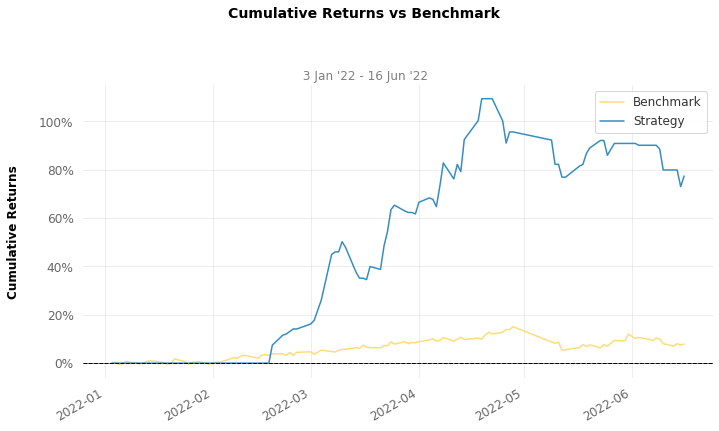

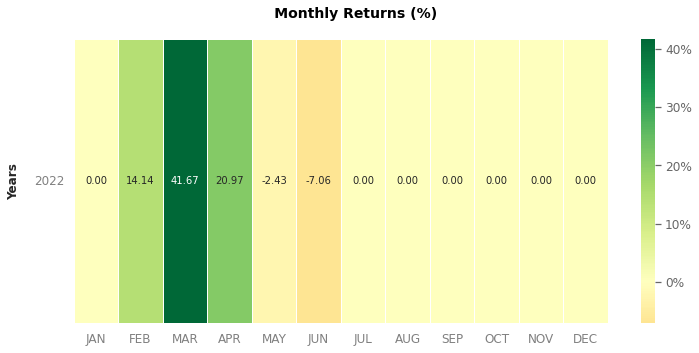

In [12]:
# Returns Visualization
i = 3
s_ret = s_ret_arr[i]

qs.plots.returns(s_ret, b_ret)
qs.plots.monthly_heatmap(s_ret)

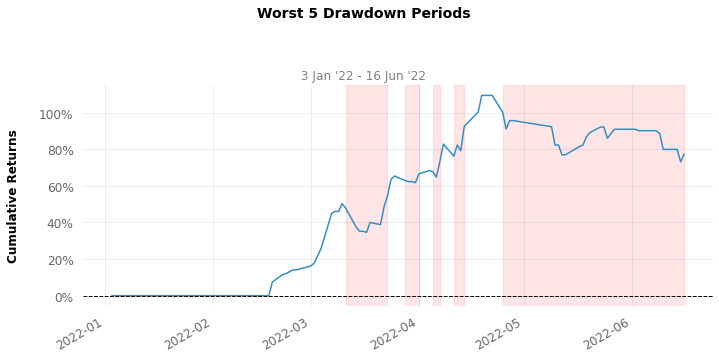

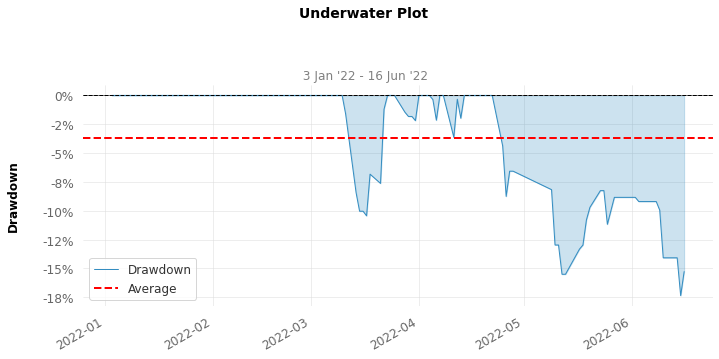

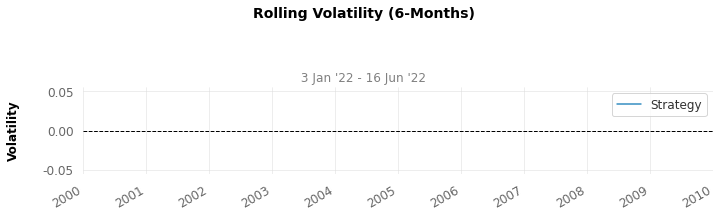

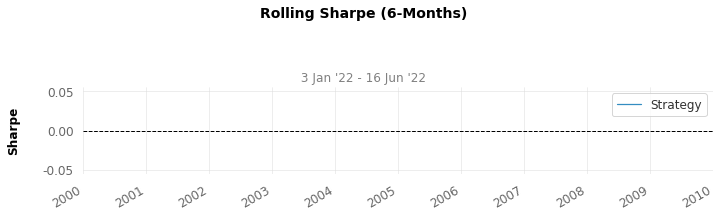

In [13]:
# Risk Visualization

qs.plots.drawdowns_periods(s_ret)
qs.plots.drawdown(s_ret)
qs.plots.rolling_volatility(s_ret)
qs.plots.rolling_sharpe(s_ret, rf=0.025)

### Additional Metrics

In [177]:
import scipy.stats as ss

# source: https://github.com/rubenbriones/Probabilistic-Sharpe-Ratio/blob/master/src/sharpe_ratio_stats.py
def expected_sr_max(trials_sr_std=0, num_trials=0, exp_sr_mean=0):
    emc = 0.5772156649
    max_z = (1 - emc) * ss.norm.ppf(1 - 1./num_trials) + emc * ss.norm.ppf(1 - 1./(num_trials * np.e))
    return exp_sr_mean + (trials_sr_std*max_z)

def prob_sr(ret, sr_benchmark=0):
    sr = qs.stats.sharpe(ret)
    n = len(ret)
    skew = ss.skew(ret)
    kurtosis = ss.kurtosis(ret, fisher=False)
    
    # Assuming SR is annualized, we need to change into periodical
    sr = sr/np.sqrt(252)
    sr_benchmark = sr_benchmark/np.sqrt(252)
    
    sr_std = np.sqrt((1 + (0.5 * sr ** 2) - (skew * sr) + (((kurtosis - 3) / 4) * sr ** 2)) / (n - 1))
    psr = ss.norm.cdf((sr - sr_benchmark) / sr_std)

    return psr

In [178]:
# Calculate Probabilistic and Deflated Sharpe Ratio
probabilistic_sr = prob_sr(s_ret_arr[i], sr_benchmark=0.025)

sr_std = pair_df['Sharpe'].std()
exp_sr_max = expected_sr_max(trials_sr_std=sr_std, num_trials=len(pair_df))
deflated_sr = prob_sr(s_ret_arr[i], sr_benchmark=exp_sr_max)

print(probabilistic_sr)
print(deflated_sr)

0.9903226677733231
0.6646833346867729
